In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import random

In [2]:
random.seed(1) 
np.random.seed(1)

# K-means and GMM

In [3]:
# true means
mean_a = [-1, -1]
mean_b = [1, -1]
mean_c = [0, 1]
true_means = np.array([mean_a, mean_b, mean_c])

In [4]:
# data generation
def generate_data(sigma, true_means):
    mean_a = true_means[0]
    cov_a = sigma * np.array([[2, 0.5], [0.5, 1]])

    mean_b = true_means[1]
    cov_b = sigma * np.array([[1, -0.5], [-0.5, 2]])

    mean_c = true_means[2]
    cov_c = sigma * np.array([[1, 0], [0, 2]])

    a = np.random.multivariate_normal(mean_a, cov_a, 100)
    b = np.random.multivariate_normal(mean_b, cov_b, 100)
    c = np.random.multivariate_normal(mean_c, cov_c, 100)
    # Merge the data into one list
    data = np.vstack([a, b, c])
    return data

In [5]:
sigma_values = [0.5, 1, 2, 4, 8]
# Define the number of clusters
k = 3
datasets = []
for sigma in sigma_values:
    datasets.append(generate_data(sigma, true_means))

true_labels = np.hstack([np.zeros(100), np.ones(100), np.full(100, 2)])

In [6]:
def cluster_acc(centers, labels, true_means, true_labels):
    distances = np.linalg.norm(centers[:, np.newaxis] - true_means, axis=2)
    # Assign cluster labels based on the mean with the smallest distance
    assigned_labels = np.argmin(distances, axis=1)
    # map
    map_labels = [assigned_labels[i] for i in labels]
    # Calculate accuracy
    correct = np.sum(map_labels == true_labels)
    total = len(true_labels)
    accuracy = correct / total

    return accuracy

## K-means

In [7]:
def kmeans(X, k, max_iters=100, num_restarts=100):
    best_centers = None
    best_labels = None
    best_cost = 0

    for _ in range(num_restarts):
        # Initialize like kmeans++
        centers = X[np.random.choice(len(X), k, replace=False)]

        for _ in range(max_iters):
            point_norm_comparison = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
            labels = np.argmin(point_norm_comparison, axis=1)
            new_centers = np.array([X[labels == j].mean(axis=0) for j in range(k)])

            if np.all(new_centers == centers):
                break

            centers = new_centers
            
        cost = np.sum((X - centers[labels]) ** 2)

        # Choose the best initialization
        if best_cost == 0 or cost < best_cost:
            best_centers = centers
            best_labels = labels
            best_cost = cost

    return best_centers, best_labels, best_cost

In [8]:
# Initialize lists to store results
kmeans_results = []
kmeans_accuracy = []

for i in range(5):
    kmeans_centers, kmeans_labels, kmeans_cost = kmeans(datasets[i], k)
    kmeans_results.append((kmeans_centers, kmeans_labels, kmeans_cost))
    accuracy = cluster_acc(kmeans_centers, kmeans_labels, true_means, true_labels)
    kmeans_accuracy.append(accuracy)
    
for i in range(len(sigma_values)):
    print(f"Sigma = {sigma_values[i]}")
    print(f"K-means cost = {kmeans_results[i][2]}")
    print(f"K-means accuracy = {kmeans_accuracy[i]}")

Sigma = 0.5
K-means cost = 318.9997737868552
K-means accuracy = 0.8633333333333333
Sigma = 1
K-means cost = 492.11980087779904
K-means accuracy = 0.68
Sigma = 2
K-means cost = 987.4248883760981
K-means accuracy = 0.6
Sigma = 4
K-means cost = 1715.5177839911385
K-means accuracy = 0.5466666666666666
Sigma = 8
K-means cost = 3105.4516519189738
K-means accuracy = 0.47


## GMM

In [9]:
class GMM:
    def __init__(self, k, max_iters=100, tol=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
    
    def fit(self, X):
        self.n_samples, self.n_features = X.shape
        # evenly assign the GMM
        self.weights = np.ones(self.k) / self.k
        # initialize the means with the data points
        self.means = X[np.random.choice(self.n_samples, self.k, replace=False)]
        # initialize the covariance matrix with identity matrix
        self.cov = np.array([np.eye(self.n_features) for _ in range(self.k)])
        
        for _ in range(self.max_iters):
            # E-step
            E = self.E_step(X)
            # M-step
            self.update_parameters(X, E)
            # Check for convergence
            if np.linalg.norm(self.old_means - self.means) < self.tol:
                break

    def E_step(self, X):
        E = np.zeros((self.n_samples, self.k))

        for i in range(self.k):
            E[:, i] = self.weights[i] * multivariate_normal.pdf(X, self.means[i], self.cov[i])

        E /= np.sum(E, axis=1)[:, np.newaxis]
        return E 
    
    def update_parameters(self, X, E):
        Nk = np.sum(E, axis=0)

        # mean
        self.old_means = self.means.copy()
        self.means = np.dot(E.T, X) / Nk[:, np.newaxis]

        # cov
        for i in range(self.k):
            diff = X - self.means[i]
            self.cov[i] = np.dot((E[:, i] * diff.T), diff) / Nk[i]

        # weights
        self.weights = Nk / self.n_samples
        

    def predict(self, X):
        E = self.E_step(X)
        return np.argmax(E, axis=1)
    
    def print_mean(self):
        return self.means

In [10]:
def neg_log_L(gmm, dataset):
    n_samples, _ = dataset.shape
    E = gmm.E_step(dataset)
    # initialize
    likelihoods = np.zeros(n_samples)
    
    for i in range(gmm.k):
        likelihoods += E[:, i] * multivariate_normal.logpdf(dataset, gmm.means[i], gmm.cov[i])
    # return the negative ones
    return -np.sum(likelihoods)

def acc_obj_gmm(dataset):
    model = GMM(k=3)
    model.fit(dataset)
    means = model.print_mean()
    pre_labels = model.predict(dataset)
    obj = neg_log_L(model, dataset)
    return pre_labels, obj, means

In [11]:
gmm_accuracy = []
gmm_obj = []

for i in range(5):
    best_label = None
    best_obj = 0
    best_means = None
    for _ in range(10):
        label, obj, means = acc_obj_gmm(datasets[i])
        if best_obj == 0 or obj < best_obj:  
            best_label = label
            best_obj = obj
            best_means = means   

    gmm_accuracy.append(cluster_acc(best_means, best_label, true_means, true_labels))
    gmm_obj.append(best_obj)
    
for i in range(len(sigma_values)):
    print(f"Sigma = {sigma_values[i]}")
    print(f"GMM objective = {gmm_obj[i]}")
    print(f"GMM accuracy = {gmm_accuracy[i]}")

Sigma = 0.5
GMM objective = 714.0235568644417
GMM accuracy = 0.87
Sigma = 1
GMM objective = 878.0370854663142
GMM accuracy = 0.6
Sigma = 2
GMM objective = 1101.0240504597568
GMM accuracy = 0.53
Sigma = 4
GMM objective = 1326.8417962952851
GMM accuracy = 0.4266666666666667
Sigma = 8
GMM objective = 1442.875505953351
GMM accuracy = 0.43


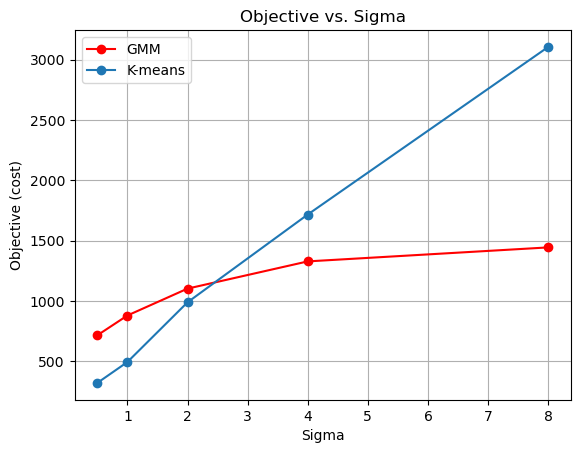

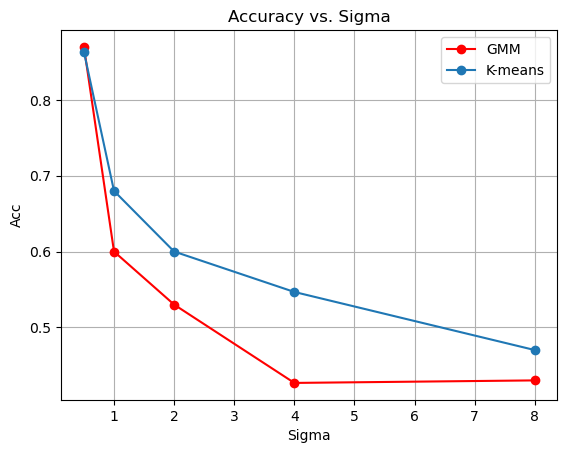

In [12]:
plt.plot(sigma_values, gmm_obj, label='GMM', marker='o', color='red')
plt.plot(sigma_values, [result[2] for result in kmeans_results], label='K-means', marker='o')
plt.xlabel('Sigma')
plt.ylabel('Objective (cost)')
plt.title('Objective vs. Sigma')
plt.legend()
plt.grid(True)
plt.savefig('1-obj.png')
plt.show()

plt.plot(sigma_values, gmm_accuracy, label='GMM', marker='o', color='red')
plt.plot(sigma_values, kmeans_accuracy, label='K-means', marker='o')
plt.xlabel('Sigma')
plt.ylabel('Acc')
plt.title('Accuracy vs. Sigma')
plt.legend()
plt.grid(True)
plt.savefig('1-acc.png')
plt.show()

# PCA and DRO

In [13]:
data_2d = np.loadtxt('data/data2D.csv', delimiter=',')
data_1000d = np.loadtxt('data/data1000D.csv', delimiter=',')

## PCA

In [14]:
def buggy_pca(X, d):
    u, s, v = np.linalg.svd(X, full_matrices=1, compute_uv=1)
    Z = X @ v[0:d, :].T
    recon = Z @ v[0:d, :]
    return Z, v[0:d, :].T, recon

def demeaned_pca(X, d):
    mean = np.mean(X, axis=0)
    X_0 = X - mean
    u, s, v = np.linalg.svd(X_0, full_matrices=1, compute_uv=1)
    Z = X_0 @ v[0:d, :].T
    recon = Z @ v[0:d, :] + mean
    return Z, v[0:d, :].T, recon

def normalized_pca(X, d):
    mean = np.mean(X, axis=0)
    sd = np.std(X, axis=0)
    X_normal = (X - mean) / sd
    u, s, v = np.linalg.svd(X_normal, full_matrices=1, compute_uv=1)
    Z = X_normal @ v[0:d, :].T
    recon = (Z @ v[0:d, :]) * sd + mean
    return Z, v[0:d, :].T, recon

 ## DRO

In [15]:
def dro(X, d):
    b = np.mean(X, axis = 0)
    b_matrix = np.outer(np.ones(X.shape[0]), b)
    X_0 = X - b_matrix
    u, s, v = np.linalg.svd(X_0, full_matrices=1, compute_uv=1)
    v_matrix = np.array(v)
#     print(v_matrix.shape)
    s_matrix = np.zeros([X.shape[0], X.shape[1]])
    for i in range(d):
        s_matrix[i, i] = s[i]
#     print(s_matrix.shape)
    u_matrix = np.array(u)
    
    Z = np.sqrt(X.shape[0]) * u_matrix[:, 0:d]
    A = (1/np.sqrt(X.shape[0])) * (s_matrix[0:d, :] @ v_matrix).T
    recon = Z @ A.T + b_matrix
    
    return Z, A, recon

In [16]:
def recon_error(X, recon):
    return np.sum((X - recon)**2)

## 2d data

In [17]:
# 2d data
Z_buggy_2d, A_buggy_2d, recon_buggy_2d = buggy_pca(data_2d, 1)
Z_demeaned_2d, A_demeaned_2d, recon_demeaned_2d = demeaned_pca(data_2d, 1)
Z_normalized_2d, A_normalized_2d, recon_normalized_2d = normalized_pca(data_2d, 1)
Z_dro_2d, A_dro_2d, recon_dro_2d = dro(data_2d, 1)

error_buggy_2d = recon_error(data_2d, recon_buggy_2d)
error_demeaned_2d = recon_error(data_2d, recon_demeaned_2d)
error_normalized_2d = recon_error(data_2d, recon_normalized_2d)
error_dro_2d = recon_error(data_2d, recon_dro_2d)
print(f"Reconstruction error (Buggy PCA) with 2d data: {error_buggy_2d:.4f}")
print(f"Reconstruction error (Demeaned PCA) with 2d data: {error_demeaned_2d:.4f}")
print(f"Reconstruction error (Normalized PCA) with 2d data: {error_normalized_2d:.4f}")
print(f"Reconstruction error (DRO) with 2d data: {error_dro_2d:.4f}")

Reconstruction error (Buggy PCA) with 2d data: 44.3452
Reconstruction error (Demeaned PCA) with 2d data: 0.5003
Reconstruction error (Normalized PCA) with 2d data: 2.4736
Reconstruction error (DRO) with 2d data: 0.5003


## 1000d data

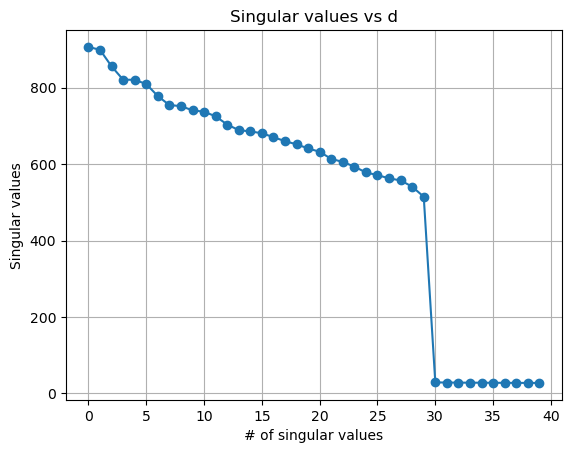

In [18]:
# singular values
X = data_1000d
b = np.mean(X, axis = 0)
b_matrix = np.outer(np.ones(X.shape[0]), b)
X_0 = X - b_matrix
s = np.linalg.svd(X_0, full_matrices=0, compute_uv=0)
plt.plot(range(40), s[0:40], marker='o')
plt.xlabel('# of singular values')
plt.ylabel('Singular values')
plt.title('Singular values vs d')
plt.grid(True)
plt.savefig('2-3-singular.png')
plt.show()

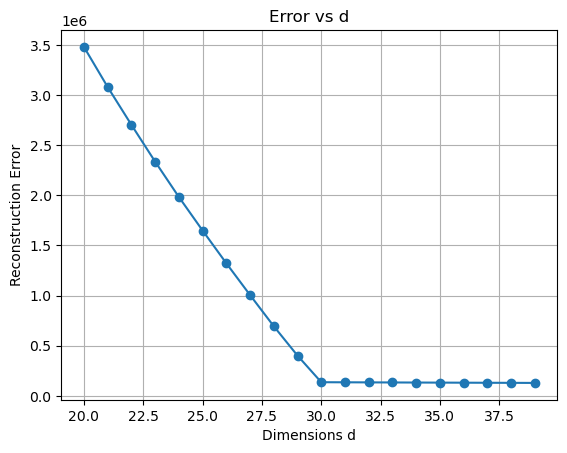

In [19]:
d_values = np.arange(20, 40)

errors = [recon_error(data_1000d, dro(data_1000d, i)[2]) for i in d_values]

plt.plot(d_values, errors, marker='o')
plt.xlabel('Dimensions d')
plt.ylabel('Reconstruction Error')
plt.title('Error vs d')
plt.grid(True)
plt.savefig('2-3-error.png')
plt.show()

In [20]:
# 1000d data
Z_buggy_1000d, A_buggy_1000d, recon_buggy_1000d = buggy_pca(data_1000d, 30)
Z_demeaned_1000d, A_demeaned_1000d, recon_demeaned_1000d = demeaned_pca(data_1000d, 30)
Z_normalized_1000d, A_normalized_1000d, recon_normalized_1000d = normalized_pca(data_1000d, 30)
Z_dro_1000d, A_dro_1000d, recon_dro_1000d = dro(data_1000d, 30)

error_buggy_1000d = recon_error(data_1000d, recon_buggy_1000d)
error_demeaned_1000d = recon_error(data_1000d, recon_demeaned_1000d)
error_normalized_1000d = recon_error(data_1000d, recon_normalized_1000d)
error_dro_1000d = recon_error(data_1000d, recon_dro_1000d)
print(f"Reconstruction error (Buggy PCA) with 1000d data: {error_buggy_1000d:.4f}")
print(f"Reconstruction error (Demeaned PCA) with 1000d data: {error_demeaned_1000d:.4f}")
print(f"Reconstruction error (Normalized PCA) with 1000d data: {error_normalized_1000d:.4f}")
print(f"Reconstruction error (DRO) with 1000d data: {error_dro_1000d:.4f}")

Reconstruction error (Buggy PCA) with 1000d data: 401365.6993
Reconstruction error (Demeaned PCA) with 1000d data: 136522.9795
Reconstruction error (Normalized PCA) with 1000d data: 136814.2905
Reconstruction error (DRO) with 1000d data: 136522.9795


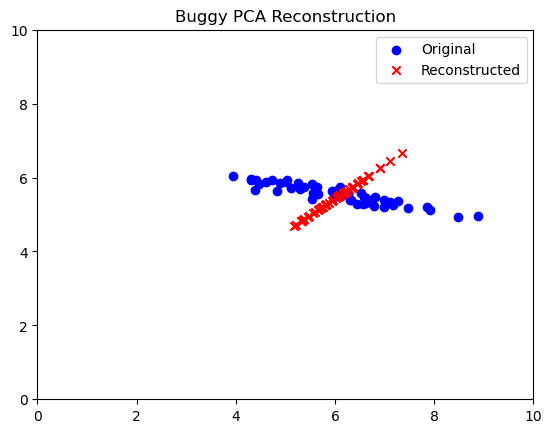

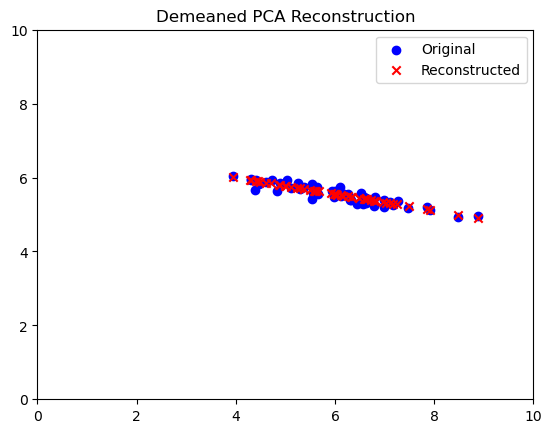

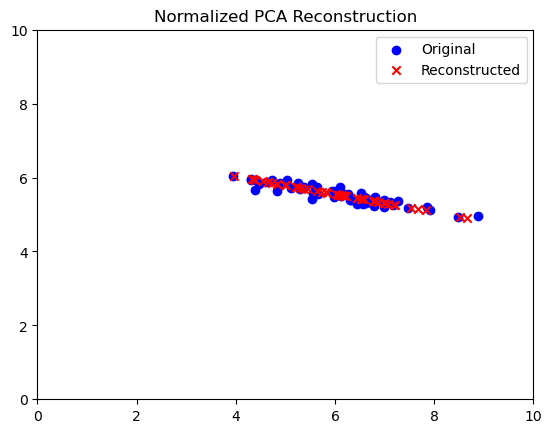

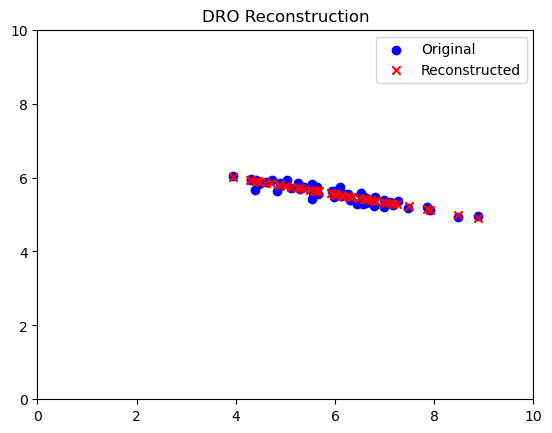

In [21]:
plt.scatter(data_2d[:, 0], data_2d[:, 1], color='blue', label='Original', marker='o')
plt.scatter(recon_buggy_2d[:, 0], recon_buggy_2d[:, 1], color='red', 
            label='Reconstructed', marker='x')
plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title('Buggy PCA Reconstruction')
plt.savefig('BPCA_recon.png')
plt.show()

plt.scatter(data_2d[:, 0], data_2d[:, 1], color='blue', label='Original', marker='o')
plt.scatter(recon_demeaned_2d[:, 0], recon_demeaned_2d[:, 1], color='red',
            label='Reconstructed', marker='x')
plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title('Demeaned PCA Reconstruction')
plt.savefig('DPCA_recon.png')
plt.show()

plt.scatter(data_2d[:, 0], data_2d[:, 1], color='blue', label='Original', marker='o')
plt.scatter(recon_normalized_2d[:, 0], recon_normalized_2d[:, 1], color='red',
            label='Reconstructed', marker='x')
plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title('Normalized PCA Reconstruction')
plt.savefig('NPCA_recon.png')
plt.show()


plt.scatter(data_2d[:, 0], data_2d[:, 1], color='blue', label='Original', marker='o')
plt.scatter(recon_dro_2d[:, 0], recon_dro_2d[:, 1], color='red',
            label='Reconstructed', marker='x')
plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title('DRO Reconstruction')
plt.savefig('DRO_recon.png')
plt.show()